# PyTorch:  Neural Network for Multiclass Classification

## Toy data

Consider a two-dimensional feature space. There are objects of three kinds (classification into three classes).<br>
Let's generate 1200 objects and draw them in the feature space.
For training data, Y must contain an integer - the class number!

X: torch.Size([1200, 2]) Y: torch.Size([1200])


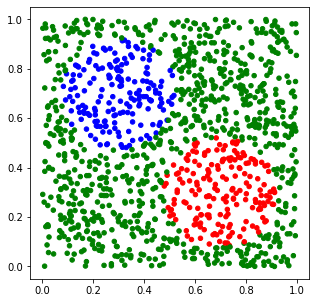

In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt  
from matplotlib import colors

X = torch.rand (1200,2)                       
C1 = (torch.sum((X - torch.tensor([0.7, 0.3]))**2, axis=1) < 0.05).float().view(-1,1)
C2 = (torch.sum((X - torch.tensor([0.3, 0.7]))**2, axis=1) < 0.05).float().view(-1,1)
C3 = (C1 * C2 == 0).float().view(-1,1)

Y = torch.argmax(torch.cat([C1,C2,C3], 1), 1)  # class numbers

print("X:", X.shape, "Y:", Y.shape)
 
plt.figure (figsize=(5, 5)) 
cmap = colors.ListedColormap(['red', 'blue', 'green'])
plt.scatter(X.numpy()[:,0], X.numpy()[:,1], c=Y.numpy(),  s=20, cmap=cmap)        
plt.show()                                                  

## Network

The three outputs of the network correspond to the probabilities of each of the three classes.
Since we use the `CrossEntropyLoss`, there is no need to set the `softmax` function at the network output!!!
$$
\mathrm{CrossEntropyLoss}(y, c) = -\,w_c\,\log\left( \frac{\exp {y_{ic}}}{ \sum_\alpha \exp{y_{i\alpha}}}\right).
$$

In [22]:
nX, nH, nY = 2, [5,7], 3
 
model = nn.Sequential(
          nn.Linear(nX, nH[0]), 
          nn.Sigmoid(),  
          nn.Linear(nH[0], nH[1]), 
          nn.Sigmoid(),   
          nn.Linear(nH[1], nY) )  

gpu = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model.to(gpu)
X = X.to(gpu)
Y = Y.to(gpu)

print(gpu)

cuda:0


## Network learning


In [23]:
loss      = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)   

In [19]:
def fit(model, X,Y, batch_size=1000, train=True):              
    sumL, sumA, numB = 0, 0, int( len(X)/batch_size )  # error, accuracy, batches
       
    idx = torch.randperm( len(X) ).to(gpu)             # permuted index list
    X, Y = X[idx], Y[idx]      

    model.train(train)                                 # important for Dropout, BatchNorm layers
    for i in range(0, numB*batch_size, batch_size):          
        xb, yb = X[i: i+batch_size], Y[i: i+batch_size] # current batch                
              
        y = model(xb)                                   # forward propagation
        L = loss(y, yb)                                 # calculate the loss
  
        if train:                                       # we are in learning mode
            optimizer.zero_grad()                       # reset the gradients        
            L.backward()                                # calculate gradients           
            optimizer.step()                            # adjusting parameters
                                     
        sumL += L.detach().item()                       # total loss (item from graph)
        
        a = y.argmax(axis=1)
        sumA += (a == yb).float().mean().item()         # class definition accuracy
         
    return sumL/numB,  sumA/numB                        # mean error and accuracy


before:      loss: 1.305e+00 accuracy: 0.1570
epoch: 10000 loss: 9.052e-03 accuracy: 0.9980   0.14s

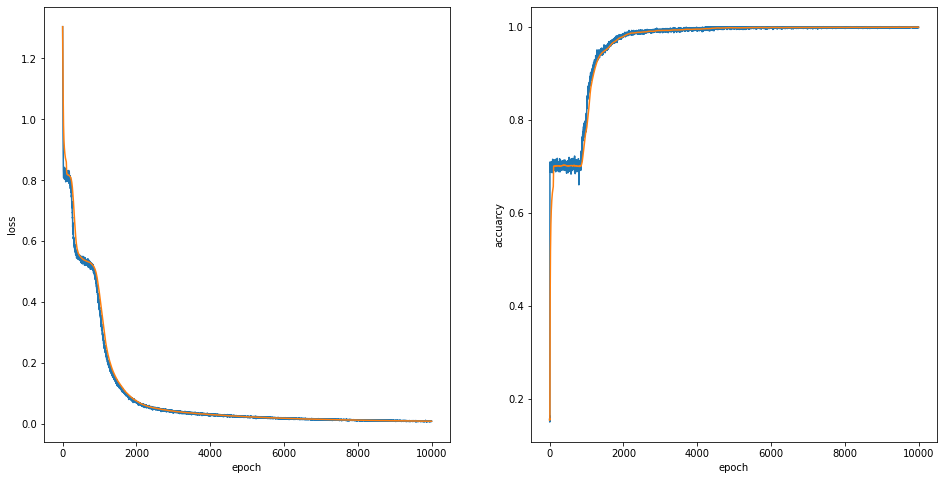

In [24]:
import time
model.to(gpu)
print( "before:      loss: %.3e accuracy: %.4f" %  fit(model, X,Y, train=False) )
history, losses, accs = [], [], []
 
beg = time.process_time()
epochs, stat1, stat2 = 10000, 1, 100                      # number of epochs
for epoch in range(1, epochs+1):                          
    L, A = fit(model, X, Y, batch_size=1000)              # one epoch
    losses.append(L); accs.  append(A)    
      
    if epoch % stat2 == 0 or epoch == epochs:   # learning output          
        print(f"\repoch: {epoch:5d} loss: {L:.3e} accuracy: {A:.4f}   {time.process_time()-beg:.2f}s", end="")   
        beg = time.process_time()
        
    if epoch % stat1 == 0:
        history.append([epoch, np.mean(losses[-stat1:]), np.mean(losses[-stat2:]), np.mean(accs[-stat1:]), np.mean(accs[-stat2:])])
        
history = np.array(history)                              # learning output
plt.figure(figsize=(16,8))              
plt.subplot(1, 2, 1);  plt.xlabel('epoch'); plt.ylabel('loss')  
plt.plot(history[:,0], history[:, 1]); 
plt.plot(history[:,0], history[:, 2]); 
plt.subplot(1, 2, 2);  plt.xlabel('epoch'); plt.ylabel('accuarcy')
plt.plot(history[:,0], history[:, 3]);
plt.plot(history[:,0], history[:, 4]);
plt.show()        

## Classification visualization

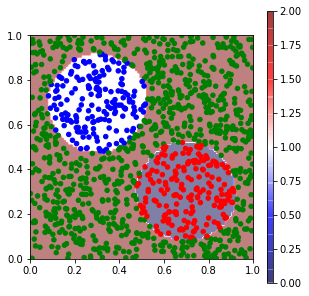

In [25]:
X_MIN, X_MAX, X_NUM = 0., 1., 100
Y_MIN, Y_MAX, Y_NUM = 0., 1., 100

x = np.linspace(X_MIN, X_MAX, X_NUM, dtype=np.float32)
y = np.linspace(Y_MIN, Y_MAX, Y_NUM, dtype=np.float32)
x, y =  np.meshgrid(x, y)    

inp = torch.cat([torch.tensor(x).view(-1,1), torch.tensor(y).view(-1,1)], 1)

z = model(inp.to(gpu)).detach().to('cpu')
z = torch.argmax( torch.softmax(z, 1), 1 ).view(X_NUM, Y_NUM)
    
plt.figure(figsize=(5,5))
plt.imshow(z, extent=[X_MIN, X_MAX, Y_MIN, Y_MAX],  origin='lower', cmap='seismic', alpha=0.5)
plt.colorbar(aspect=50) 
cmap = colors.ListedColormap(['red', 'blue', 'green'])
plt.scatter(X.cpu().numpy()[:,0], X.cpu().numpy()[:,1], c=Y.cpu().numpy(),  s=20, cmap=cmap)       

plt.show()